In [ ]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [4]:
def tchebichef_polynomials(N, order):
    """
    Calcule les polynômes de Tchebichef de manière stable par récurrence.
    Remplace avantageusement la formule directe de l'Eq. (3).
    """
    M = np.zeros((order, N))
    x = np.arange(N)
    
    # p = 0
    M[0, :] = 1.0
    
    if order > 1:
        # p = 1
        M[1, :] = (2.0 * x - N + 1.0) / N
        
    # p > 1 : Relation de récurrence de Mukundan
    for p in range(2, order):
        term1 = ((2.0 * p - 1.0) * (2.0 * x - N + 1.0)) / (p * N)
        term2 = ((p - 1.0) / p) * (1.0 - ((p - 1.0)**2 / (N**2)))
        M[p, :] = term1 * M[p-1, :] - term2 * M[p-2, :]
        
    return M

def calculate_rho(N, order):
    """
    Calcule la constante de normalisation rho(p,N).
    Implémente la récurrence de l'Équation (4).
    """
    rho = np.zeros(order)
    rho[0] = N
    for p in range(1, order):
        # Formule récursive pour l'efficacité numérique
        term1 = (N**2 - p**2) / (N**2)
        term2 = (2*p - 1) / (2*p + 1)
        rho[p] = term1 * term2 * rho[p-1]
    return rho

In [5]:
def decompose_2d(image, order):
    """Décomposition robuste gérant les images rectangulaires."""
    H, W = image.shape
    M_h = tchebichef_polynomials(H, order)
    M_w = tchebichef_polynomials(W, order)
    
    rho_h = calculate_rho(H, order)
    rho_w = calculate_rho(W, order)
    
    T_raw = M_h @ image @ M_w.T
    C_pq = 1.0 / np.outer(rho_h, rho_w)
    return T_raw * C_pq

def reconstruct_2d(moments, shape_originale):
    """Reconstruction à partir des moments calculés."""
    H, W = shape_originale
    order = moments.shape[0]
    M_h = tchebichef_polynomials(H, order)
    M_w = tchebichef_polynomials(W, order)
    return M_h.T @ moments @ M_w

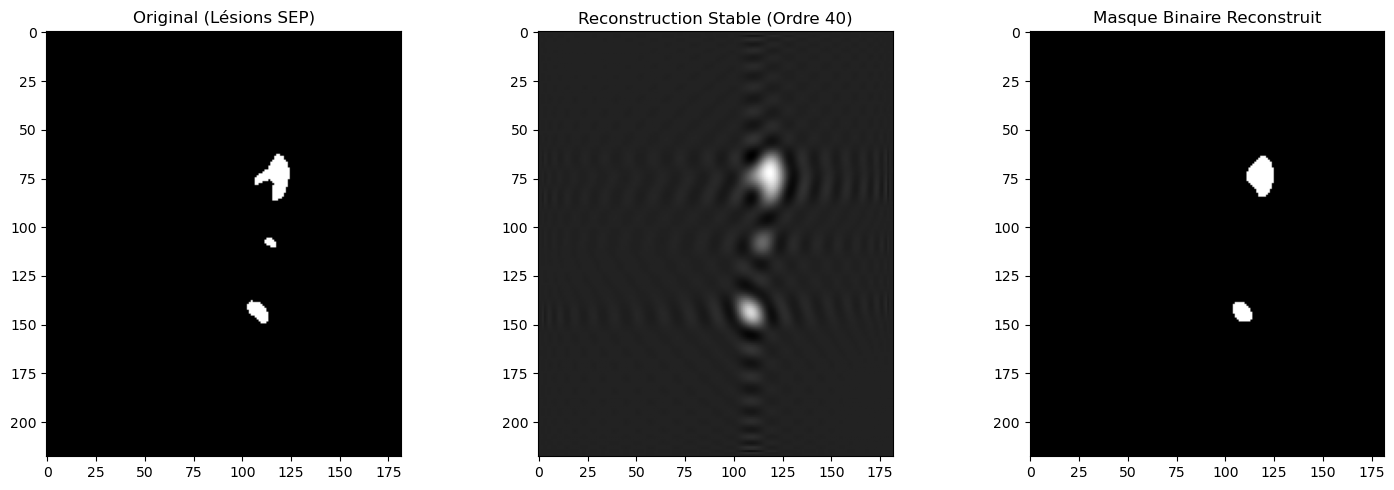

Erreur quadratique moyenne (MSE) : 2.399392e-03


In [6]:
# 1. Chargement des données (Chemin conservé)
mask_path = "../../27919209/MSLesSegDataset/train/P1/T1/P1_T1_MASK.nii.gz"
mask_sitk = sitk.ReadImage(mask_path)
mask_array = sitk.GetArrayFromImage(mask_sitk).astype(np.float32)

# 2. Extraction d'une coupe 2D
slice_idx = mask_array.shape[0] // 2
sample_slice = mask_array[slice_idx, :, :]

# Paramètres
ORDRE = 40 # Indispensable pour la précision des formes SEP [cite: 89, 140]

# 3. Décomposition / Reconstruction STABLE
moments_2d = decompose_2d(sample_slice, ORDRE)
reconstruction = reconstruct_2d(moments_2d, sample_slice.shape)

# Nettoyage (Seuillage)
mask_final = (reconstruction > 0.5).astype(np.uint8)

# 4. Affichage des résultats
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original (Lésions SEP)")
plt.imshow(sample_slice, cmap='gray')

plt.subplot(1, 3, 2)
plt.title(f"Reconstruction Stable (Ordre {ORDRE})")
plt.imshow(reconstruction, cmap='gray') # Utilisation de gray pour plus de clarté

plt.subplot(1, 3, 3)
plt.title("Masque Binaire Reconstruit")
plt.imshow(mask_final, cmap='gray')

plt.tight_layout()
plt.show()

# 5. Métrique de succès
mse = np.mean((sample_slice - reconstruction)**2)
print(f"Erreur quadratique moyenne (MSE) : {mse:.6e}")

In [7]:
def decompose_3d(volume, order):
    """
    Décomposition d'un volume 3D en moments de Tchebichef T_pqr.
    Supporte les volumes non-cubiques (D, H, W).
    """
    D, H, W = volume.shape
    
    # 1. Génération des bases pour chaque axe
    M_d = tchebichef_polynomials(D, order)
    M_h = tchebichef_polynomials(H, order)
    M_w = tchebichef_polynomials(W, order)
    
    # 2. Constantes de normalisation rho (Eq. 4)
    rho_d = calculate_rho(D, order)
    rho_h = calculate_rho(H, order)
    rho_w = calculate_rho(W, order)
    
    # 3. Triple projection (Somme pondérée)
    # p,q,r = ordres | i,j,k = coordonnées (z,y,x)
    T_raw = np.einsum('pi,qj,rk,ijk->pqr', M_d, M_h, M_w, volume)
    
    # 4. Application de C_pqr = 1 / (rho_p * rho_q * rho_r)
    C_pqr = 1.0 / (rho_d[:, None, None] * rho_h[None, :, None] * rho_w[None, None, :])
    return T_raw * C_pqr

def reconstruct_3d(moments, target_shape):
    """
    Reconstruction du volume 3D à partir des moments T_pqr.
    """
    D, H, W = target_shape
    order = moments.shape[0]
    
    M_d = tchebichef_polynomials(D, order)
    M_h = tchebichef_polynomials(H, order)
    M_w = tchebichef_polynomials(W, order)
    
    # Transformation inverse
    return np.einsum('pi,qj,rk,pqr->ijk', M_d, M_h, M_w, moments)

Décomposition 3D (Ordre 20)...
Reconstruction 3D...


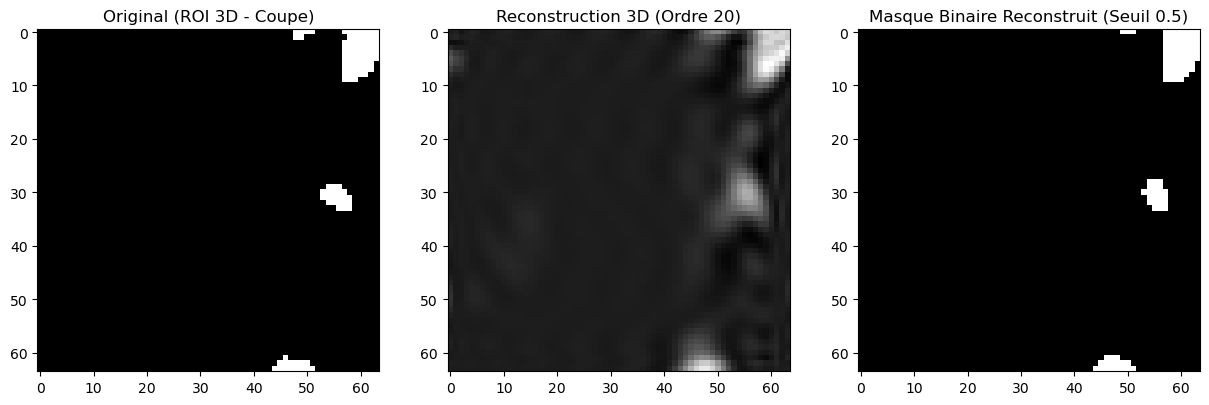

MSE 3D : 6.831778e-03


In [8]:
# 1. Paramètres
ORDRE_3D = 20 # Commencer à 20 pour la 3D (suffisant pour capturer les formes)

# 2. Extraction d'une zone d'intérêt (ROI) 
# On prend un cube de 64x64x64 autour du centre pour le test
z, y, x = mask_array.shape
roi_size = 32
sample_volume = mask_array[z//2-roi_size:z//2+roi_size, 
                           y//2-roi_size:y//2+roi_size, 
                           x//2-roi_size:x//2+roi_size]

# 3. Calculs
print(f"Décomposition 3D (Ordre {ORDRE_3D})...")
moments_3d = decompose_3d(sample_volume, ORDRE_3D)

print("Reconstruction 3D...")
reconstruction_3d = reconstruct_3d(moments_3d, sample_volume.shape)

# 4. Visualisation (on affiche une coupe axiale au milieu du volume)
mid = roi_size
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original (ROI 3D - Coupe)")
plt.imshow(sample_volume[mid, :, :], cmap='gray')

plt.subplot(1, 3, 2)
plt.title(f"Reconstruction 3D (Ordre {ORDRE_3D})")
plt.imshow(reconstruction_3d[mid, :, :], cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Masque Binaire Reconstruit (Seuil 0.5)")
plt.imshow(reconstruction_3d[mid, :, :] > 0.5, cmap='gray')

plt.show()

mse_3d = np.mean((sample_volume - reconstruction_3d)**2)
print(f"MSE 3D : {mse_3d:.6e}")

## On va essayer le code sur des formes 2D bien définies

In [13]:
from matplotlib.path import Path

def generate_random_spots(size=128, n_spots=15):
    """Génère une image avec de multiples petites formes aléatoires."""
    np.random.seed(42) 
    img = np.zeros((size, size), dtype=np.float32)
    for _ in range(n_spots):
        shape_type = np.random.choice(['circle', 'rect'])
        y, x = np.random.randint(10, size-10, size=2)
        s = np.random.randint(2, 5) # Taille très petite
        
        if shape_type == 'circle':
            grid_y, grid_x = np.ogrid[:size, :size]
            mask = (grid_x - x)**2 + (grid_y - y)**2 <= s**2
            img[mask] = 1.0
        else:
            img[y-s:y+s, x-s:x+s] = 1.0
    return img

def generate_test_shapes(size=128):
    shapes = {}
    base = np.zeros((size, size), dtype=np.float32)
    center = size // 2
    y, x = np.ogrid[:size, :size]

    # 1. Anneau
    ring = base.copy()
    mask_outer = (x - center)**2 + (y - center)**2 <= (size // 3)**2
    mask_inner = (x - center)**2 + (y - center)**2 <= (size // 6)**2
    ring[mask_outer] = 1.0
    ring[mask_inner] = 0.0
    shapes["Anneau"] = ring

    # 2. Carré
    square = base.copy()
    side = size // 4
    square[center-side:center+side, center-side:center+side] = 1.0
    shapes["Carré"] = square

    # 3. Ellipse
    ellipse = base.copy()
    mask_ellipse = ((x - center)**2 / (size//3)**2) + ((y - center)**2 / (size//6)**2) <= 1
    ellipse[mask_ellipse] = 1.0
    shapes["Ellipse"] = ellipse

    # 4. Croix
    cross = base.copy()
    thickness = size // 10
    length = size // 3
    cross[center-thickness:center+thickness, center-length:center+length] = 1.0
    cross[center-length:center+length, center-thickness:center+thickness] = 1.0
    shapes["Croix"] = cross

    # 5. Vraie Étoile
    star = base.copy()
    num_points = 5
    radius_outer = size // 3
    radius_inner = size // 7
    points = []
    for i in range(num_points * 2):
        r = radius_outer if i % 2 == 0 else radius_inner
        angle = i * np.pi / num_points - np.pi / 2
        points.append([center + r * np.cos(angle), center + r * np.sin(angle)])
    path = Path(np.array(points))
    grid_y, grid_x = np.mgrid[:size, :size]
    grid_points = np.vstack((grid_x.ravel(), grid_y.ravel())).T
    shapes["Étoile"] = path.contains_points(grid_points).reshape((size, size)).astype(np.float32)

    # 6. AJOUT : Taches aléatoires (Multi-objets)
    shapes["Taches Aléatoires"] = generate_random_spots(size)

    return shapes

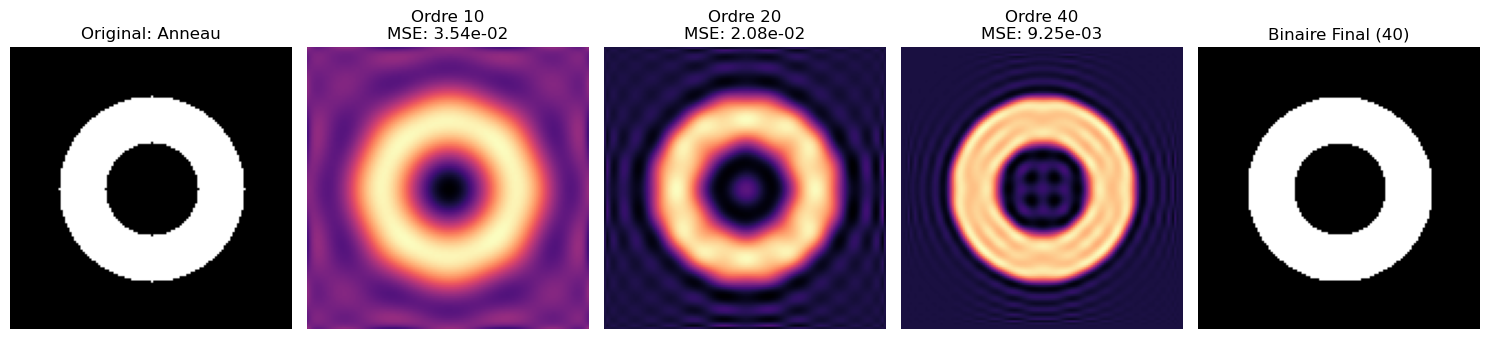

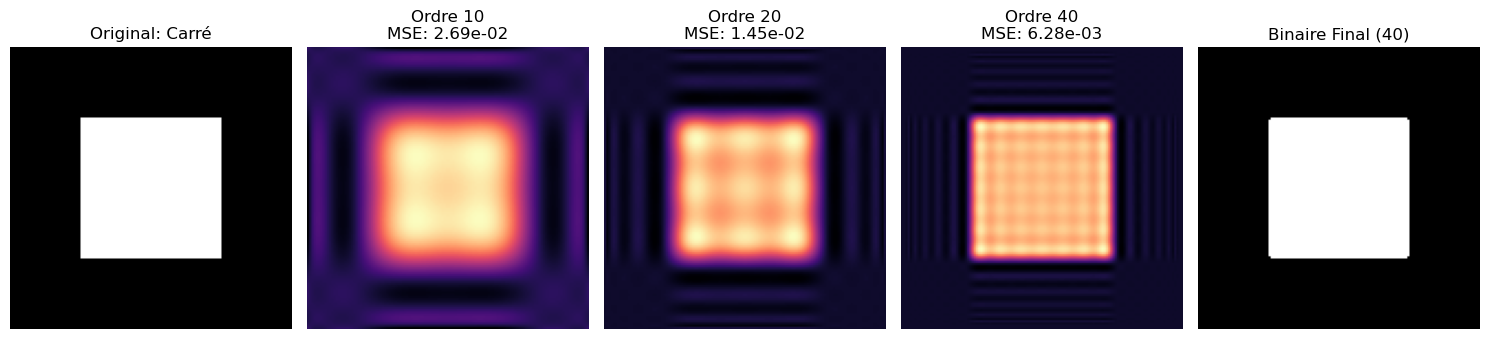

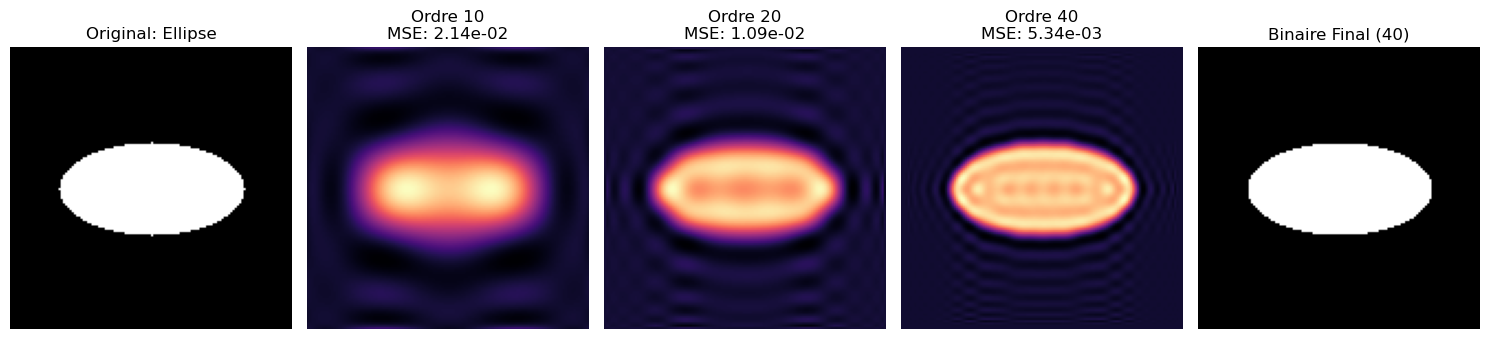

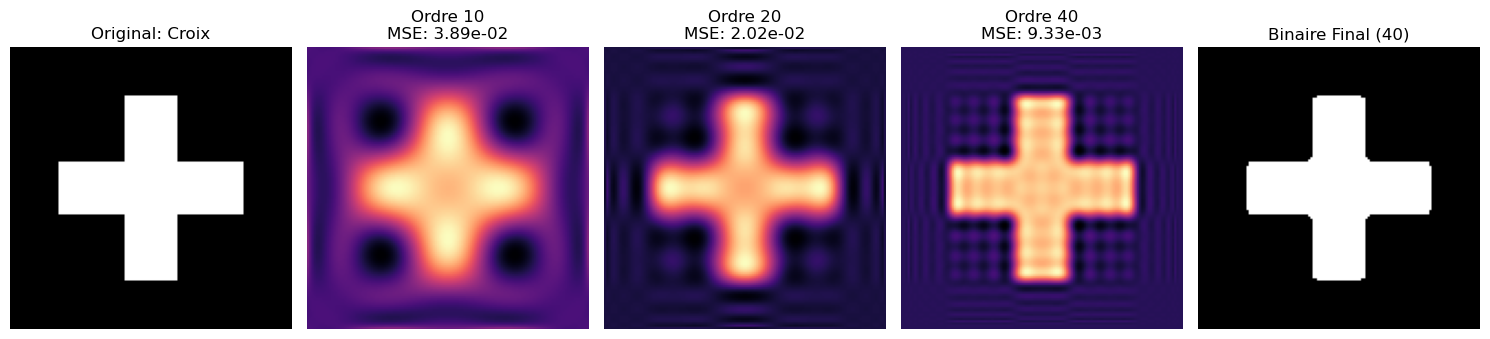

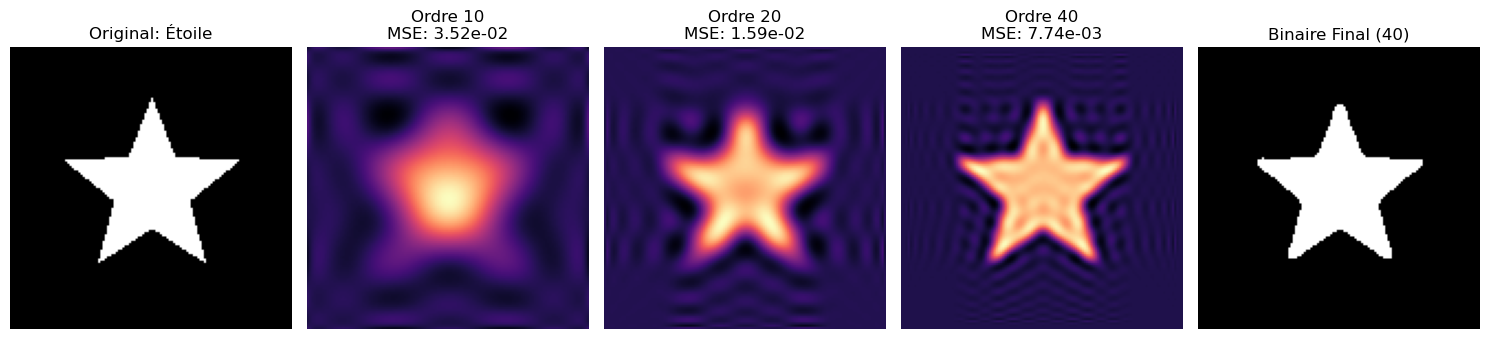

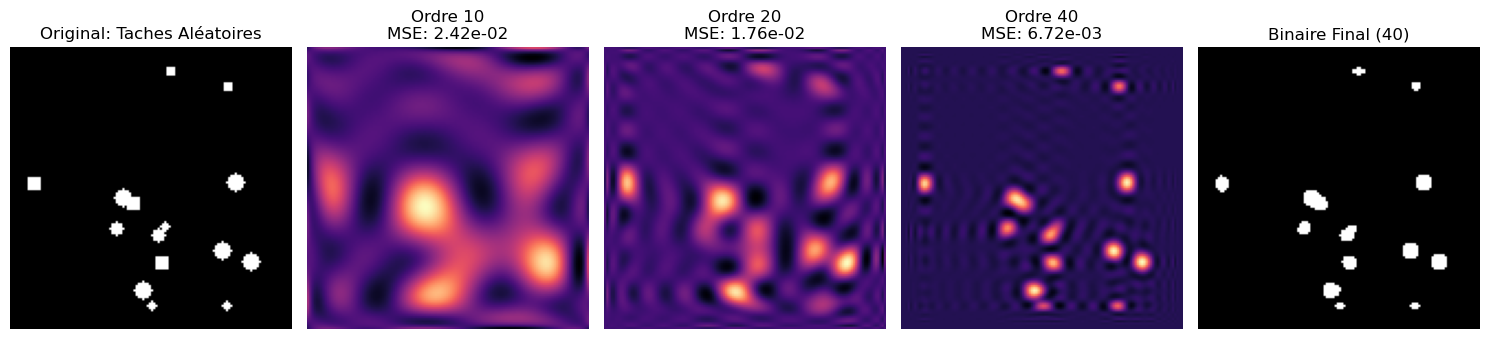

In [14]:
# --- Initialisation ---
test_shapes = generate_test_shapes(128)
ORDRES_A_TESTER = [10, 20, 40] 

for name, original in test_shapes.items():
    plt.figure(figsize=(15, 4))
    
    # Affichage original
    plt.subplot(1, len(ORDRES_A_TESTER) + 2, 1)
    plt.title(f"Original: {name}")
    plt.imshow(original, cmap='gray')
    plt.axis('off')

    # Test de différents ordres
    for i, current_order in enumerate(ORDRES_A_TESTER):
        # Utilisation de VOS fonctions stables
        moments = decompose_2d(original, current_order)
        recon = reconstruct_2d(moments, original.shape)
        
        # Calcul de l'erreur
        current_mse = np.mean((original - recon)**2)
        
        plt.subplot(1, len(ORDRES_A_TESTER) + 2, i + 2)
        plt.title(f"Ordre {current_order}\nMSE: {current_mse:.2e}")
        plt.imshow(recon, cmap='magma') 
        plt.axis('off')

    # Masque binaire final à l'ordre le plus élevé
    mask_bin = (recon > 0.5).astype(np.uint8)
    plt.subplot(1, len(ORDRES_A_TESTER) + 2, len(ORDRES_A_TESTER) + 2)
    plt.title(f"Binaire Final ({ORDRES_A_TESTER[-1]})")
    plt.imshow(mask_bin, cmap='gray')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()